# Regression exploration

In this problem set you will explore working with regression. The first part of the notebook will define basic functions and import data that we need. Note in particular that I load `pandas` and `seaborn`. Both of these packages might have to be installed before you can run this notebook - you can modify the code below to not use them but as they are both powerful and useful I recommend you get them working.

Pandas is a library designed to handle data in a flexible way. It is derived from `R`'s data frames and Pandas is particularly nice for moderate sized datasets and dataset that mix datatypes. To learn more about `pandas` you can check out the project web page: [http://pandas.pydata.org/](http://pandas.pydata.org/). 

Seaborn is a visualisation package particularly suited for statistical data. It builds on `matplotlib` but adds functionality and improves the default appearance (although not all defaults are that great IMHO).There is plenty of information on this on the Seaborn web page: [https://seaborn.pydata.org/index.html](https://seaborn.pydata.org/index.html)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from astroML.datasets import fetch_sdss_sspp
from astroML.plotting import hist
import seaborn as sns
import pandas as pd
import sys
try:
    import cPickle
except:
    import _pickle as cPickle
from sklearn.linear_model import Ridge, Lasso

# The matplotlib inline special command must be commented out if you run this as 
# a script or on the ipython/python command line.
%matplotlib inline

In [7]:
# This sets the default appearance of seaborn and its colour palette
sns.set(style="white")
sns.set_palette('colorblind')

In [29]:
def pickle_to_file(data, fname):
    """Save a variable simply to a file"""
    try:
        fh = open(fname, 'wb')
        cPickle.dump(data, fh)
        fh.close()
    except:
        print("Pickling failed!", sys.exc_info()[0])

def pickle_from_file(fname):
    """Restore a variable saved with pickle_to_file"""
    try:
        fh = open(fname, 'rb')
        data = cPickle.load(fh)
        fh.close()
    except:
        print("Loading pickled data failed!", sys.exc_info()[0])
        data = None

    return data


In [9]:
# This reads in data on stellar sources from the SDSS.
# If running this on a computer without the setup recommended on blackboard, it will
# download the data from the net the first time called.
data = fetch_sdss_sspp()

It can be useful to know what is in the data array! One good way is to check the [documentation of fetch_sdss_spp](http://www.astroml.org/modules/generated/astroML.datasets.fetch_sdss_sspp.html), another is to print `data.dtype.names` which will show you the name of the columns in the data.

In [10]:
print(data.dtype.names)

('ra', 'dec', 'Ar', 'upsf', 'uErr', 'gpsf', 'gErr', 'rpsf', 'rErr', 'ipsf', 'iErr', 'zpsf', 'zErr', 'pmL', 'pmB', 'pmErr', 'mjd', 'plate', 'fiber', 'SNR', 'FeH', 'FeHErr', 'Teff', 'TeffErr', 'logg', 'loggErr', 'alphFe', 'alphFeErr', 'radVel', 'radVelErr')


In [11]:
# Extract some data. 
ug = data['upsf']-data['gpsf']
gr = data['gpsf']-data['rpsf']
ri = data['rpsf']-data['ipsf']
iz = data['ipsf']-data['zpsf']
T = data['Teff']

In [12]:
# Understand what the line below does! Try without the transpose and see the shape.
X = np.vstack((ug, gr, ri, iz, T)).T
M = np.vstack((ug, gr, ri, iz)).T

## Visualisation of the data

A good way to visualise data like this is to use a pair plot grid - this is provided by Seaborn in the `PairGrid` function. This allows lower and upper and diagonals to show different things. The lower half and diagonals show Kernel Density plots - we will come back to these later in the course - for now think of them as smooth versions of 2D and 1D histograms respectively. (this does take a bit to run btw! but to make it quicker I only use the first 1000 points).

/Users/jarle/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


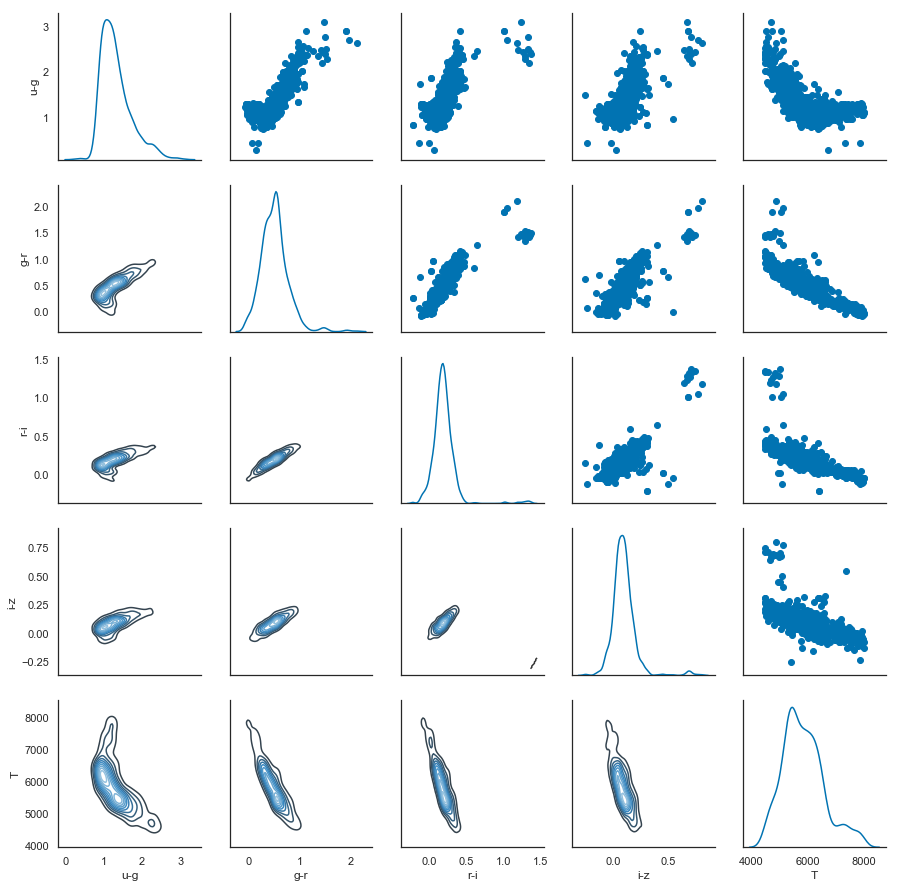

In [13]:
# Here I make a Pandas's DataFrame 
df = pd.DataFrame(X[0:1000, :], columns=['u-g', 'g-r', 'r-i', 'i-z', 'T'])
g = sns.PairGrid(df, diag_sharey=False)

# KDE plots are a form of smooth 2D histograms. This command ensures that the 
# panels below the diagonal all show the distributions as these smoothed 2D histograms using default
# settings (which might be a bad idea!)
g.map_lower(sns.kdeplot, cmap="Blues_d")

# This ensures that the panels above the diagonal shows the data relationships using a normal scatter plot.
g.map_upper(plt.scatter)

# Finally on the diagonal we could show a normal histogram - here I use a kernel density estimate of the 
# distribution which is a smoother version of the histogram.
g.map_diag(sns.kdeplot)

There is plenty of co-linearity in this data. Let me now assume that we can write

$$T = \theta_0 + \theta_1 (u-g) + \theta_2 (g-r) + \theta_3 (r-i) + \theta_5 (i-z) $$

and we want to constrain $\theta$.

Your task now is to do this for different types of regression. The foundation of the code is provided in the lecture notes of lecture 1 - feel free to use that!

## Problem 1: Regular linear regression

a) Fit a model to the data to predict $T$, find $\theta$ and plot the residuals between the best fit regression line and the true values as a function of the temperature $T$. What do you conclude about your model?


b) Pick 8 stars at random from the sample and redo the fit. Do this twice - are the best fit lines consistent? [different people will reach different conclusions here!]

## Solution: 

a)
Plan of attack: Import LinearRegression from astroML (or other package), fit the data and calculate the predictions. I'll do this line by line first.

b) I'll write a small function to select a subsample and run the fit - looking ahead to the other problems I'll let it work with different regression methods.

In [14]:
from astroML.linear_model import LinearRegression

In [15]:
# This is the standard setup for fitting. I use temperatures in units of 10^4 K to avoid enormous numbers in the fit
model = LinearRegression(fit_intercept=True)
res = model.fit(M, T/1e4)
Tpred = model.predict(M)
residuals = Tpred*1e4-T
relative_residuals = residuals/T
c = list(res.coef_)
print(" The best-fit model is:\n   T = {0:.3f}+ {1:.3f} (u-g) + {2:.3f} (g-r) + {3:.3f} (r-i) + {4:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4]))


 The best-fit model is:
   T = 0.690+ 0.025 (u-g) + -0.261 (g-r) + -0.083 (r-i) + 0.035 (i-z)


Now for a first go at the residual plot. This just creates two scatter plots with the residuals on the left and the relative residuals on the right. This is not a very good plot.

Text(0, 0.5, '$(T_{pred}-T)/T$')

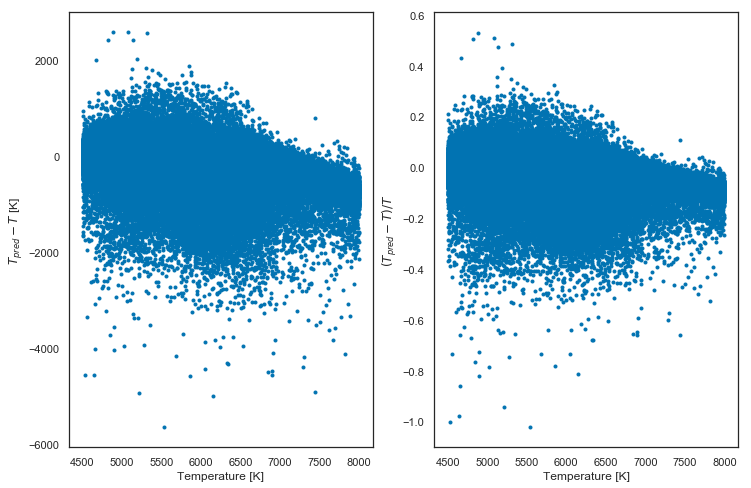

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
axes[0].scatter(T, residuals, marker='.')
axes[0].set_xlabel('Temperature [K]')
axes[0].set_ylabel(r'$T_{pred}-T$ [K]')

axes[1].scatter(T, relative_residuals, marker='.')
axes[1].set_xlabel('Temperature [K]')
axes[1].set_ylabel(r'$(T_{pred}-T)/T$')


Now what is bad about these figures? There are a few problems:

 1. They obscure the data. There are so many datapoints you can't see any structure.
 2. They actually provide very little information as such. 
 3. The labels are arguably too small.
 4. My impression is that the aspect ratio is wrong for the data.
 5. The residuals should be symmetric around zero if all is well, but as the y-axis is asymmetric it is hard to judge whether the residuals are symmetric around zero
 
These two figures also provide very similar information. Although it is not exactly the same, I'll just improve the relative residual plot on the left. 

So how can we tackle these issues? 

**Obscured data**: This is relatively easy. We can use transparency of the points (that is the solution I'll use below), and we can obscure the individual data points more by creating a 2D histogram or a 2D kernel density plot, but since that is the next lecture I won't do that. 

**Little information**: With so much data it is useful to overplot, say the median trend line on the data and possibly a regression fit to the data to see whether there is a slope to data, or to colour the points by some colour.  Of course to carry out this properly we should look at the trend of residuals with the various colours & there are a bunch of diagnostic plots one can use for regression models. 

The median of a value Y in a small window in x is called the running or rolling median or sometimes the median trend line. Calculation of a running median for large data can be a bit slow but you can speed things up if your data is sorted or various other situations. Below I calculate it in a very simple way but there are also other things one can do.

**Labels**: Straightforward fix.

**Aspect ratio**: This is easily fixed, and in particular for us because we will now only plot one panel.

**Y-range**: We just set the y-limits to be symmetric around zero

In [17]:
def running_median(x, y, N=10, binsize=None):
    """Calculate the median in N windows, or windows of size binsize.
    
    This ignores all edge effects - caveat emptor
    """

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # This finds the bins that each x should go in.
    # This is convenient for expanding the routine to accept other functions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    # I also want the x-positions in the bins. I use mean for that
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

In [18]:
x_m_regular, med_regular, bins = running_median(T, relative_residuals, binsize=100)

/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(-0.5, 0.5)

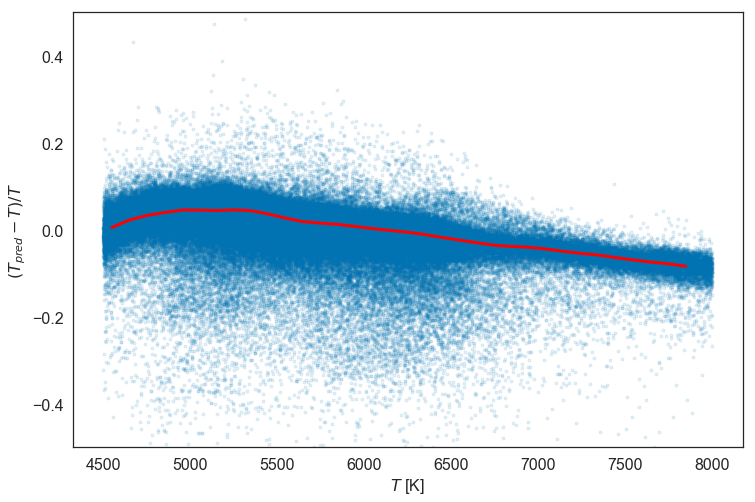

In [19]:
# I'll still use the subplots notation so that it is easy to modify if I want to add more panels.

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.scatter(T, relative_residuals, marker='.', alpha=0.1)
ax.plot(x_m_regular, med_regular, lw=3, color='red')

ax.set_xlabel(r'$T$ [K]', fontsize=16)
ax.set_ylabel(r'$(T_{pred}-T)/T$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.5,0.5)


Moving now to problem b), we first define a function that can be used to get subsets

In [20]:
def fit_one_subset(M, T, indices, ridge=False, lasso=False, standard=True, alpha=0.05):
    """
    Run a subset of the data given by the indices input
    
    Arguments:
    M: The model data (here the colours) [numpy array]
    T: The target variable (here the temperature) [numpy array]
    indices: The indices of the data to use for the fit [numpy array or list-like]
    
    Keywords:
    ridge: Set this if you want to fit with Ridge regression [default=False]
    lasso: Set this if you want to fit with Lasso regression [default=False]
    standard: Set thist to do standard linear regression     [default=true]
    alpha: The regularisation parameter for Lasso or Ridge regression [default=0.05]
    
    Return:
    model, fit, predictions
    
    """
    
    if standard:
        model = LinearRegression(fit_intercept=True)
    elif ridge:
        model = Ridge(alpha=alpha, fit_intercept=True, normalize=True)
    elif lasso:
        model = Lasso(alpha=alpha, fit_intercept=True, normalize=True)
    
    res = model.fit(M[indices, :], T[indices]/1e4)
    
    # Note that we predict on _ALL_ elements
    predicted = res.predict(M)
    
    return model, res, predicted

def run_many_subsets(M, T, N_per=10, N_sets=1000, ridge=False, lasso=False, standard=True, alpha=0.05):
    """
    Fit N_sets of N_per objects.
    """
    
    if (N_per*N_sets > len(T)):
        print("It is not possible to have this combination of N_per and N_sets")
        return None
    
    # This is the index array
    inds = np.arange(len(T))
    # Now shuffle it.
    np.random.shuffle(inds)
    
    subset_coefs = np.zeros((N_sets, 5))
    
    fitted = []
    predicted = []
    for i in range(N_sets):
        subset = inds[i*N_per:(i+1)*N_per]

        model, res, pred = fit_one_subset(M, T, subset, ridge=ridge, lasso=lasso, standard=standard, alpha=alpha)
        if standard:
            subset_coefs[i, :] = res.coef_
        else:
            # This is a bit annoying..
            subset_coefs[i, 0] = res.intercept_
            subset_coefs[i, 1:] = res.coef_
        fitted.append(res)
        predicted.append(pred)
        
    return subset_coefs, fitted, predicted

Armed with this function we can fit for 8 random objects quite easily. The logic is perhaps a bit opaque, so let me run through what `run_many_subsets` does: 

* It first creates an array that contains the indices of all the data.
* Then we shuffle this to have a random order. 
* After this shuffling, the first 8 elements will be one set of random data and the next 8 elements will be another random set of data. 

When I run `run_many_subsets` I can then specify that I want 8 per subset and that I need 2 sets. 

In [21]:
coefs8, fits8, pred8 = run_many_subsets(M, T, N_per=8, N_sets=2, standard=True)


Now the question is how one compares the two fits. This is not trivial and there is no "correct" solution to this. One way would be to use the formal uncertainties on the parameter estimates, but here I will simply look visually at the median residuals. Different people will solve this in different ways.

In [22]:
x_m8_1, y_m8_1, bins8_1 = running_median(T, (pred8[0]*1e4-T)/T, binsize=100)
x_m8_2, y_m8_2, bins8_2 = running_median(T, (pred8[1]*1e4-T)/T, binsize=100)

/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(-0.4, 0.4)

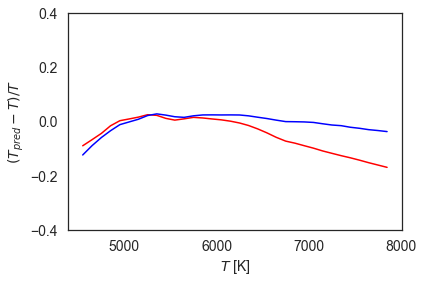

In [23]:
plt.plot(x_m8_1, y_m8_1, color='red')
plt.plot(x_m8_2, y_m8_2, color='blue')

plt.xlabel(r'$T$ [K]', fontsize=14)
plt.ylabel(r'$(T_{pred}-T)/T$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(-0.4, 0.4)

If you run these commands many times you will find that sometimes the two curves agree very well, and sometimes they differ dramatically.

## Problem 2: Ridge regression

Repeat a) & b) from problem 1 for RidgeRegression. How does the answer for b) differ from that for regular linear regression.

## Solution

This is by construction very similar to the previous so I will not go through this in detail. 

What matters here is the choice of the regularising constant - $\alpha$ below here, although $\lambda$ is more common in the literature (it is a bad variable name in Python, hence $\alpha$). In the example here I use a very large value intentionally - this will lead to the fit being worse than with regular regression.

In [24]:
# This is the standard setup for fitting. I use temperatures in units of 10^4 K to avoid enormous numbers in the fit
model = Ridge(alpha=2, fit_intercept=True, normalize=True)
res = model.fit(M, T/1e4)
Tpred = model.predict(M)
residuals = Tpred*1e4-T
relative_residuals = residuals/T

# Note that the intercept for ridge regression is somewhat hidden..
c = [res.intercept_]
[c.append(coeff) for coeff in res.coef_]

print(" The best-fit model is:\n   T = {0:.3f}+ {1:.3f} (u-g) + {2:.3f} (g-r) + {3:.3f} (r-i) + {4:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4]))


 The best-fit model is:
   T = 0.655+ -0.019 (u-g) + -0.053 (g-r) + -0.092 (r-i) + -0.093 (i-z)


/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


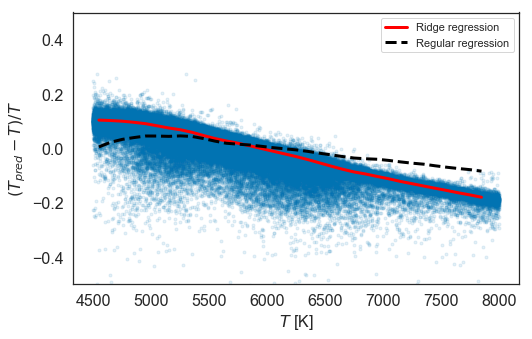

In [25]:
# I'll still use the subplots notation so that it is easy to modify if I want to add more panels.
x_m_ridge, med_ridge, bins = running_median(T, relative_residuals, binsize=100)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
ax.scatter(T, relative_residuals, marker='.', alpha=0.1)
ax.plot(x_m_ridge, med_ridge, lw=3, color='red', label='Ridge regression')
ax.plot(x_m_regular, med_regular, lw=3, color='black', ls='dashed', label='Regular regression')

ax.set_xlabel(r'$T$ [K]', fontsize=16)
ax.set_ylabel(r'$(T_{pred}-T)/T$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.5,0.5)
ax.legend()

So one thing that is noticeable is that the residuals are identical. Let us now look at small samples

/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


(-0.4, 0.4)

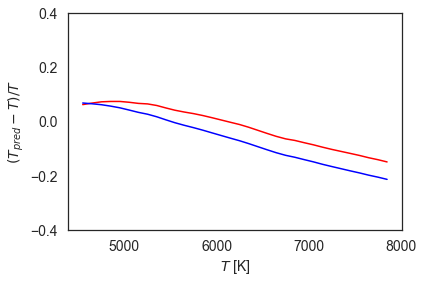

In [26]:
coefs8, fits8, pred8 = run_many_subsets(M, T, N_per=8, N_sets=2, standard=False, ridge=True, alpha=2.0)

x_m8_1, y_m8_1, bins8_1 = running_median(T, (pred8[0]*1e4-T)/T, binsize=100)
x_m8_2, y_m8_2, bins8_2 = running_median(T, (pred8[1]*1e4-T)/T, binsize=100)

plt.plot(x_m8_1, y_m8_1, color='red')
plt.plot(x_m8_2, y_m8_2, color='blue')

plt.xlabel(r'$T$ [K]', fontsize=14)
plt.ylabel(r'$(T_{pred}-T)/T$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.ylim(-0.4, 0.4)

So if you run this many times, you will find that the residual lines do not vary very much at all. This is a reflection of the regularised nature of ridge regression (and because I used a large regularing value!)

## Problem 3: LASSO regression

Finally repeat the tasks in problem 1 for LASSO regression. Reflect on how the answer for b) changes relative to the other two questions.

In the lecture we saw that for a sufficiently large regularisation parameter, $\lambda$, the only remaining term is the one for $\theta_2$ - can you visually explain why this is?

## Solution

Again, this is not very different from ridge regression. **However** my installation of `sklearn` has suddenly stoppped working  for Lasso - no idea why, but it means I cannot provide a proper solution here.

In [27]:
# This is the standard setup for fitting. I use temperatures in units of 10^4 K to avoid enormous numbers in the fit
model = Lasso(alpha=0.01, fit_intercept=True, normalize=True)
res = model.fit(M[0:10,:], T[0:10]/1e4)
Tpred = model.predict(M)
residuals = Tpred*1e4-T
relative_residuals = residuals/T

# Note that the intercept for ridge regression is somewhat hidden..
c = [res.intercept_]
[c.append(coeff) for coeff in res.coef_]

print(" The best-fit model is:\n   T = {0:.3f}+ {1:.3f} (u-g) + {2:.3f} (g-r) + {3:.3f} (r-i) + {4:.3f} (i-z)".format(c[0], c[1], c[2], c[3], c[4]))


 The best-fit model is:
   T = 0.600+ -0.018 (u-g) + -0.000 (g-r) + 0.000 (r-i) + -0.000 (i-z)


/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jarle/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


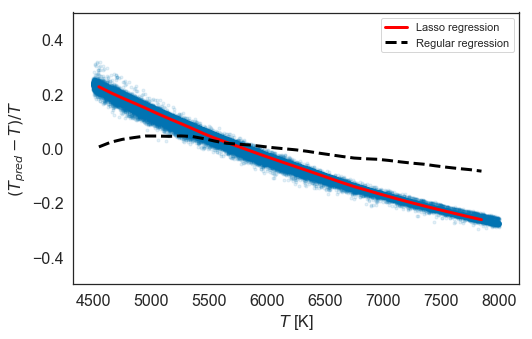

In [28]:
# I'll still use the subplots notation so that it is easy to modify if I want to add more panels.
x_m_lasso, med_lasso, bins = running_median(T, relative_residuals, binsize=100)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8, 5))
ax.scatter(T, relative_residuals, marker='.', alpha=0.1)
ax.plot(x_m_lasso, med_lasso, lw=3, color='red', label='Lasso regression')
ax.plot(x_m_regular, med_regular, lw=3, color='black', ls='dashed', label='Regular regression')

ax.set_xlabel(r'$T$ [K]', fontsize=16)
ax.set_ylabel(r'$(T_{pred}-T)/T$', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.5,0.5)
ax.legend()